# Introduction

"All models are wrong, some are useful" - George box

This notebook analyzes effect of socio-demograhic trends on businesses, identifying those trends to make business decisions effectively. In today's world in highly competitive environment it is very crucial to take decisions in timely manner to stay in the game,to target right customers and right time, to run marketing campaign effectively to thrive int he business. This notebook experiments with the tools and geo-spatial dataset provided by Precisely. The primary goal of this hackathon is to determine if location that company wants to start its business is good or not. For this different datasets have been provided [details are in data evaluation/Engineering section] to analayze socio-demographic trends at that location. The mathematical model predicts not only recommendation about viablity of the location but also predicts revenue/Profitibility and hiring count at this location.

Since team has liberty to choose any one type of business and help them to determine next viable location for their business, after going through dataset Discover has chosen "Libraries" for performing analytics for this hackathon.  

One may argue that Libraries are not a business because they are not meant for making profits. But to sustain at any physical location involves cost and expenditure in different forms like employee cost, lease of property, contracts for books and what not.. If libraries are opened without doing any study about location then it may enventually incur financial loss and gets closed. It requires proper study and needs to have sustainable model. Then Libraries can do lot of things to maintain their monthly cost to stay at that location. Sustainable libraries are ultimately great indicator of social cohesiveness.[1]

# Business Understanding

The hackathon environent has provided data for wide range of businesses (Point of Interests, Yelp reviews). The goal of this hackathon is to provide insights for selected business from the provided datasets which includes point of interest, Yelp reviews for businesses, Consumer behvior/income, census and traffic data with the help from Geo-spatial Libraries provided by Precisely. The primary objective is to predict if particular location is suitable to start your business. The mathematical model should able to predict if the given address is suitable to start new branch/business along with estimated revenue and employees required.

Objective is provide insights for Libraries in United States from the data available and build a model to predict if new library can be opened at any given location and number of employees required and estimate revenues from the location.

# Data Evaluation/Engineering

### Point Of Interest Dataset
First step is to find records that are belong to all libraries. Hackthon's Point of Interest Dataset has total 23714 records i.e. these are total number of different locations for the libraries across United States. As shown in below cells libraries are located in all states although numbers are different for every state. There is only one library "
TANGIPAHOA PARISH LIBRARY" has 0 number employees in this data. The google search indicates this library at this location is closed and therefore removed from this analysis.

In [0]:
%sql 
select trade_division,group_name,main_class,count(*) from provided_datasets.usa_points_of_insterest_001 
where main_class='LIBRARIES' and employee_here>0 group by trade_division,group_name,main_class order by count(*) desc

trade_division,group_name,main_class,count(1)
DIVISION I. - SERVICES,EDUCATIONAL SERVICES,LIBRARIES,23714


## Python code to retrieve data
Before going into geospatial analysis below are diffrent statistics about libraries. Below cell contains code to retrive data for visualizations. Next cells contains visuals and decription of the plots.

In [0]:
top_20_states = spark.sql("select STABB,count(*) total_libraries  from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by STABB order by count(*) desc limit 20").toPandas()

top_20_states_emp = spark.sql("select STABB,SUM(EMPLOYEE_HERE) total_employees  from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by STABB order by SUM(EMPLOYEE_HERE) desc limit 20").toPandas()

top_20_by_libraries = spark.sql("select name,count(*) total_locations from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by name order by count(*) desc limit 20").toPandas()

top_20_by_libby_emp = spark.sql("select name,SUM(EMPLOYEE_HERE) total_employees from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by name order by SUM(EMPLOYEE_HERE) desc limit 20").toPandas()

top_20_by_sales = spark.sql("select name,SUM(SALES_VOLUME_US_DOLLARS) total_SALES from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by name order by SUM(SALES_VOLUME_US_DOLLARS) desc limit 20").toPandas()

top_lib_by_state = spark.sql("select trim(STABB) State,trim(name) Name from provided_datasets.usa_points_of_insterest_001 where  main_class='LIBRARIES' and name IN ( select name from ( select name,SUM(SALES_VOLUME_LOCAL) total_SALES from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by name order by SUM(SALES_VOLUME_LOCAL) desc limit 10))").toPandas()

all_libraries = spark.sql("select name,longitude,latitude,employee_here,sales_volume_us_dollars from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0").toPandas()

florida_lib_ds = spark.sql("select * from t_dis_poi_route50").toPandas()


In [0]:
pip install descartes


Python interpreter will be restarted.
Collecting descartes
 Downloading descartes-1.1.0-py3-none-any.whl (5.8 kB)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.8/site-packages (from descartes) (3.2.2)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->descartes) (2.4.7)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->descartes) (1.3.0)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->descartes) (2.8.1)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->descartes) (0.10.0)
Requirement already satisfied: numpy>=1.11 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->descartes) (1.19.2)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.8/site-packages (from python-dateutil>=2.1->matplotlib->descartes) (1.15.0)
Installing collected packages: descartes
Successfully installed descartes-1.1.0
WARNING: You are using pip version 20.2.4; however, version 21.3 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-43e8e310-f8f4-4d20-914e-a0665d72a1ec/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
pip install geopandas

Python interpreter will be restarted.
Collecting geopandas
 Downloading geopandas-0.10.2-py2.py3-none-any.whl (1.0 MB)
Collecting pyproj>=2.2.0
 Downloading pyproj-3.2.1-cp38-cp38-manylinux2010_x86_64.whl (6.3 MB)
Collecting fiona>=1.8
 Downloading Fiona-1.8.20-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (15.4 MB)
Requirement already satisfied: pandas>=0.25.0 in /databricks/python3/lib/python3.8/site-packages (from geopandas) (1.1.5)
Collecting shapely>=1.6
 Downloading Shapely-1.7.1-cp38-cp38-manylinux1_x86_64.whl (1.0 MB)
Requirement already satisfied: certifi in /databricks/python3/lib/python3.8/site-packages (from pyproj>=2.2.0->geopandas) (2020.12.5)
Collecting attrs>=17
 Downloading attrs-21.2.0-py2.py3-none-any.whl (53 kB)
Collecting click-plugins>=1.0
 Downloading click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
Requirement already satisfied: setuptools in /databricks/python3/lib/python3.8/site-packages (from fiona>=1.8->geopandas) (50.3.1)
Requirement already satisfied: six>=1.7 in /databricks/python3/lib/python3.8/site-packages (from fiona>=1.8->geopandas) (1.15.0)
Collecting munch
 Downloading munch-2.5.0-py2.py3-none-any.whl (10 kB)
Collecting click>=4.0
 Downloading click-8.0.3-py3-none-any.whl (97 kB)
Collecting cligj>=0.5
 Downloading cligj-0.7.2-py3-none-any.whl (7.1 kB)
Requirement already satisfied: python-dateutil>=2.7.3 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.25.0->geopandas) (2.8.1)
Requirement already satisfied: numpy>=1.15.4 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.25.0->geopandas) (1.19.2)
Requirement already satisfied: pytz>=2017.2 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.25.0->geopandas) (2020.5)
Installing collected packages: pyproj, attrs, click, click-plugins, munch, cligj, fiona, shapely, geopandas
Successfully installed attrs-21.2.0 click-8.0.3 click-plugins-1.1.1 cligj-0.7.2 fiona-1.8.20 geopandas-0.10.2 munch-2.5.0 pyproj-3.2.1 shapely-1.7.1
WARNING: You are using pip version 20.2.4; however, version 21.3 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-43e8e310-f8f4-4d20-914e-a0665d72a1ec/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
pip install plotly

Python interpreter will be restarted.
Requirement already satisfied: plotly in /databricks/python3/lib/python3.8/site-packages (4.14.3)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from plotly) (1.15.0)
Requirement already satisfied: retrying>=1.3.3 in /databricks/python3/lib/python3.8/site-packages (from plotly) (1.3.3)
WARNING: You are using pip version 20.2.4; however, version 21.3 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-43e8e310-f8f4-4d20-914e-a0665d72a1ec/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
pip install yellowbrick

Python interpreter will be restarted.
Collecting yellowbrick
 Downloading yellowbrick-1.3.post1-py3-none-any.whl (271 kB)
Requirement already satisfied: scipy>=1.0.0 in /databricks/python3/lib/python3.8/site-packages (from yellowbrick) (1.5.2)
Requirement already satisfied: scikit-learn>=0.20 in /databricks/python3/lib/python3.8/site-packages (from yellowbrick) (0.23.2)
Requirement already satisfied: numpy<1.20,>=1.16.0 in /databricks/python3/lib/python3.8/site-packages (from yellowbrick) (1.19.2)
Requirement already satisfied: cycler>=0.10.0 in /databricks/python3/lib/python3.8/site-packages (from yellowbrick) (0.10.0)
Requirement already satisfied: matplotlib!=3.0.0,>=2.0.2 in /databricks/python3/lib/python3.8/site-packages (from yellowbrick) (3.2.2)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.20->yellowbrick) (2.1.0)
Requirement already satisfied: joblib>=0.11 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.20->yellowbrick) (0.17.0)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from cycler>=0.10.0->yellowbrick) (1.15.0)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib!=3.0.0,>=2.0.2->yellowbrick) (2.4.7)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib!=3.0.0,>=2.0.2->yellowbrick) (2.8.1)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib!=3.0.0,>=2.0.2->yellowbrick) (1.3.0)
Installing collected packages: yellowbrick
Successfully installed yellowbrick-1.3.post1
WARNING: You are using pip version 20.2.4; however, version 21.3 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-43e8e310-f8f4-4d20-914e-a0665d72a1ec/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
import matplotlib.pyplot as plt
import descartes
import geopandas 
from shapely.geometry import Point, Polygon
%matplotlib inline

## Data Visualization from full Library dataset

This section shows some observations from the data using plots. This section includes insights from the all records available in point of interest dataset. 

### Limitation of the Hackathon environment

Analysis with all 23,714 distinct addresses apparently not possible in this environment. Geofencing fails with memory error (Java exception) when 400 distinct addreses are fed Spark engine. With 100 Geofencing succeeds but Spatital search fails with same Memory erros. Therefore for this hackathon only top 50 libraries that are having top sales are included.

### Top 20 States by Total Libraries and Total Employees

California, New York and Texas are top three states with total number of Libraries in the United States. These states also employs more people in libraries compared to other states.

Out[34]:

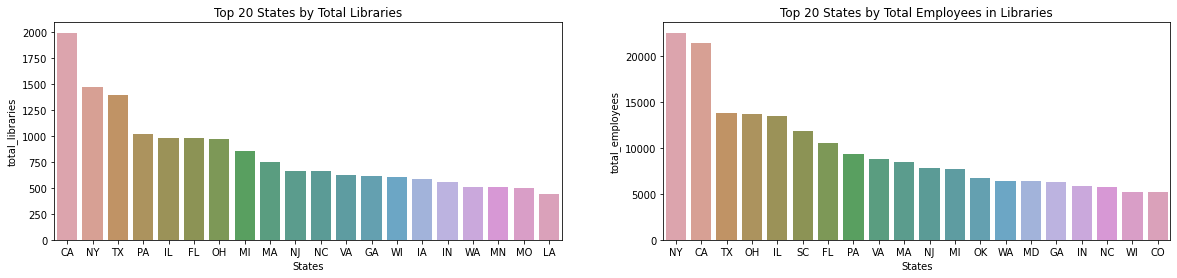

Text(0.5, 0, 'States')

In [0]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2,figsize=(20,4))

axes[0].set_title('Top 20 States by Total Libraries')
axes[1].set_title('Top 20 States by Total Employees in Libraries')

x = sns.barplot(ax=axes[0],x="STABB", y="total_libraries", data=top_20_states, saturation=.5)
x.set_xlabel("States")
x = sns.barplot(ax=axes[1],x="STABB", y="total_employees", data=top_20_states_emp, saturation=.5)
x.set_xlabel("States")

### Top 20 Libraries by Total locations

County of Los Angeles,  City of Los Angeles and Queens Borough Public Library are located in more than 50 locations across United States.

Out[46]:

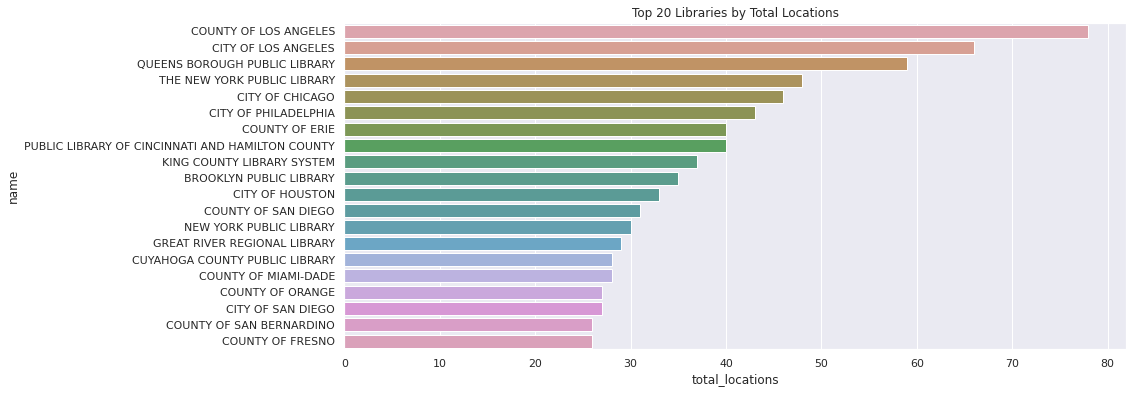

Text(0.5, 1.0, 'Top 20 Libraries by Total Locations')

In [0]:
sns.set(rc = {'figure.figsize':(14,6)})

sns.barplot(x="total_locations", y="name", data=top_20_by_libraries, saturation=.5,orient = 'h').set_title("Top 20 Libraries by Total Locations")

### Top 20 Libraries by Total Employees

State of California and University of Oklahoma employs each employ more than 5000 in library in United States which is largest in United States compared to any other libraries. But dont know why State of South carolina which present only at two locations in South carolina has so many employees in library. Spatial analysis after combining with other dataset may help in understanding this. But just from the point of interest dataset its not clear.

Out[47]:

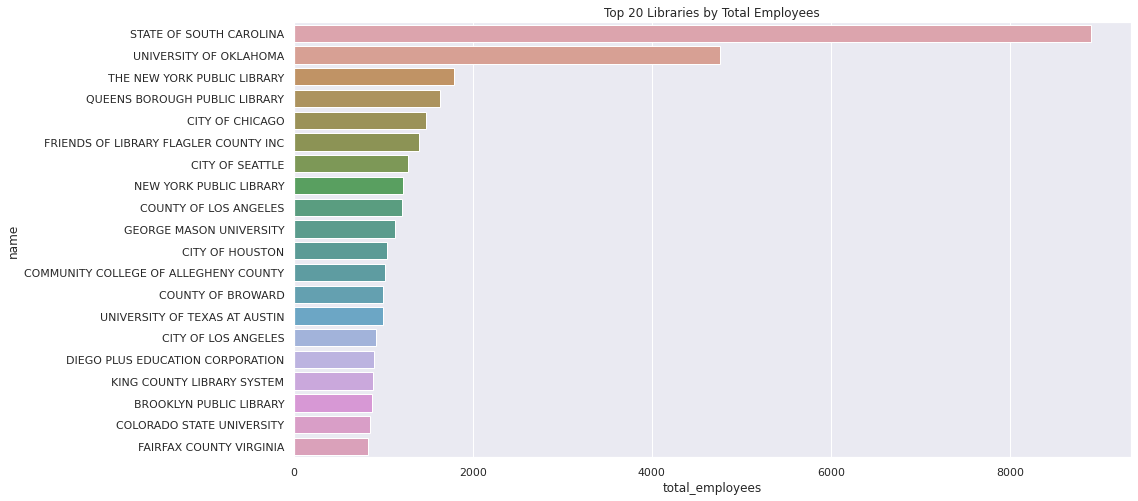

Text(0.5, 1.0, 'Top 20 Libraries by Total Employees')

In [0]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x="total_employees", y="name", data=top_20_by_libby_emp, saturation=.5,orient = 'h').set_title("Top 20 Libraries by Total Employees")

### Top 20 Libraries by Sales

CHEGG, UTAH STATE University and New York Public Library are top 3 libraries that generates revenue of more than USD 3 million. CHEGG being a topmost with more than 6m USD revenue indicates that this can be profit making business.

CHEGG physcially present only in California's one location but largest revenue maker

Out[53]:

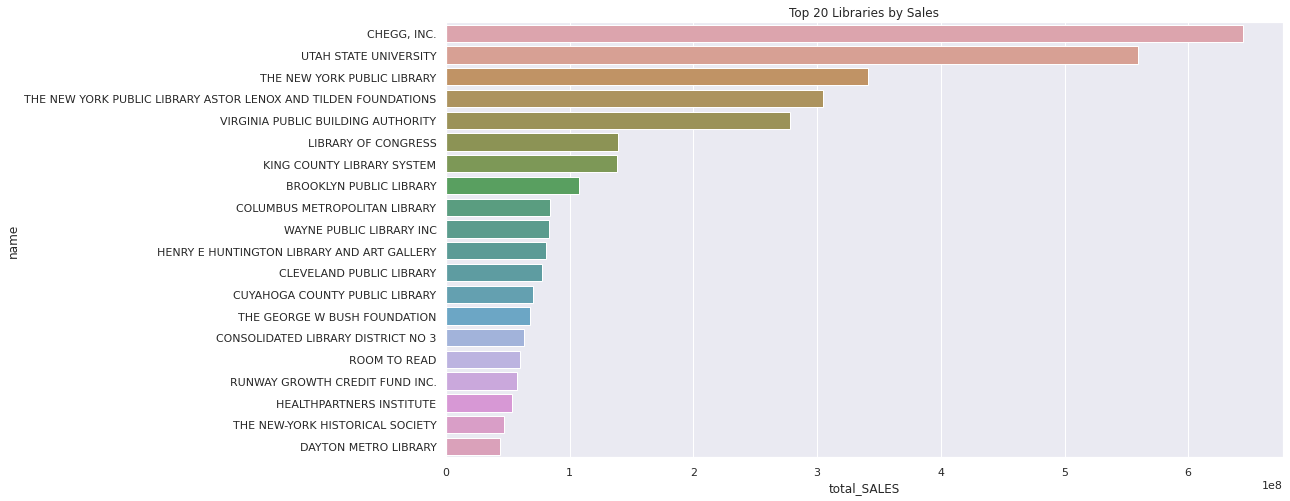

Text(0.5, 1.0, 'Top 20 Libraries by Sales')

In [0]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x="total_SALES", y="name", data=top_20_by_sales, saturation=.5,orient = 'h').set_title("Top 20 Libraries by Sales")


### Top 10 Libraries by Sales

This is how top 10 sales generator are distributed in different state. All top 10 libraries that generates highest revenue are physcially present only in one state. New york Public Library, Brooklyn Public Library, King county Public Library are present in more than 10 locations in same State. All apparently Prime Locations. But there is not much information available in the provided dataset on how they generate revenues, What services they provide etc. At this moment it is clear it is not necessary to be present in multiple locations to generate higher revenues.

It is not surprising to see that CHEGG present in only one location, but we know they provide lot of revenues from online educational services including study materials. Their presence is online as well as offline makes them more competitive and profitable.

Out[86]:

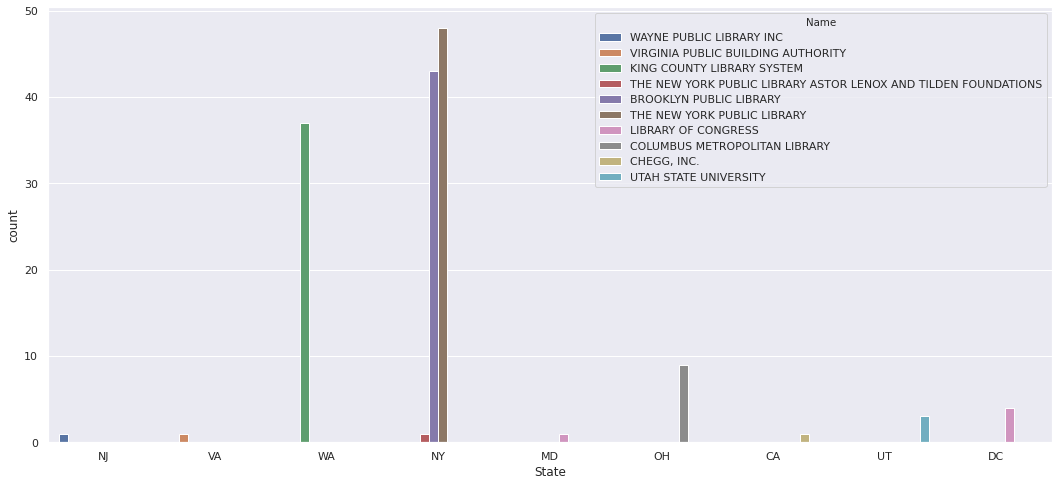

<matplotlib.axes._subplots.AxesSubplot at 0x7f177e501790>

In [0]:
sns.set(rc = {'figure.figsize':(18,8)})
sns.countplot(x="State", hue="Name", data=top_lib_by_state)


## Geo-Spatial analysis

This section shows Libraries across USA on the map. It gives nice visualization of all locations from the dataset.

### Library Map (All Libraries in USA)

Below map shows locations of all libraries from the dataset across USA. Libraries are located almost everywhere in United States. East cost has more number of libraries compared to West coast. As shown Top 3 Libraries (CHEGG, UTAH, NEW YORK Libraries) with highest earning/sales are from highly populated areas. These are also areas where standard of living is high compared to other locations. But high population may not be the sole reason for making so much profits compared to other libraries.

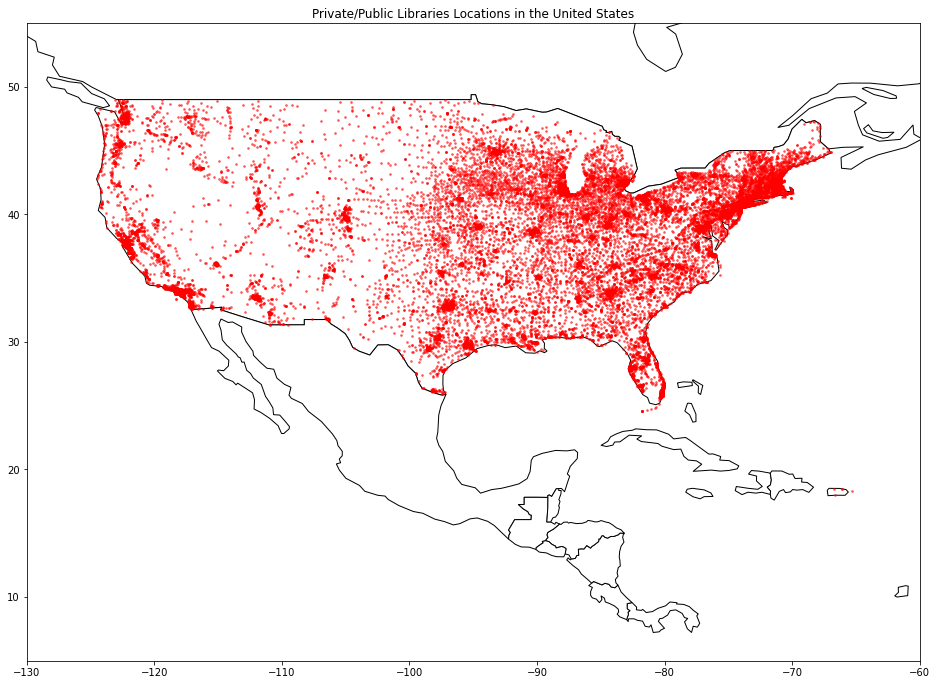

In [0]:
gdf = geopandas.GeoDataFrame(
    all_libraries, geometry=geopandas.points_from_xy(all_libraries.longitude, all_libraries.latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize=(16,12))
gdf['color'] = gdf.employee_here

ax.set_xlim(-130, -60)
ax.set_ylim(5, 55)
gdf.plot(ax=ax, color='r', markersize=3, alpha=0.5)
plt.title('Private/Public Libraries Locations in the United States')
plt.show()

# Model Preparations

Libraries dataset obtained in previous steps contains 23K libraries locations and with geofencing it locates all addreses within 5 mins of the libraries which aims to get demographic and audience expenditure details about potential consumers. This turns dataset to become huge and it was becoming time consuming to pull all possible addresses. This hackathon environment probably doesn't support that much memory and speed. Spark fails to load all possible records even with 100 libraries. Therefore Total libraries for modeling has been set limited to 50 libraries from Florida and loaded in delta table t_dis_poi_route50.

Following process followed to retrive all possible addresses for every library locations.

 1.Run precisely functions to obtain polygon which contains all reachable locations from the library locations. 
 
 2.Run GeoSpatial function to convert all longitude/latititude to PBKEY  which is actuall physical address
 
 3.This newly obtained table contains all possible addresses closer to library (5-10 mins). For 50 Libraries in Florida it has found total 700K addresses each with unique key PBKEY
 
 4.For the modeling this table joined with census table. 
 
Due to time limitation and also due to limitation of environment for the modeling purpose only census data shall be used. The model can be further improved by adding more information from other datasets like audience profile, family income/expenditure. they are useful features and may improve accuracy of the model later.
 
 
 Therefore This notebook is using Three tables
 1. t_dis_poi_route50
 2. gv_usa_population_census_by_001
 3. usa_address_fabric_001


Joined using PBKEY. Number of records further trimmed to 20K due to slowness.


**Output variables**

 1.Employee_count
 
 2.sales_volume_us_dollars
 
These target variables to be used to make a decision whether given location is good for the business or not. Based on predicted sales and total number of employees required management can make a decision whether to invest in that location or not.
 
**Input variables**

  All other variables from both datasets.

**Algorithm**

This notebook uses Random forest with Multioutput regression using ScikitLearn Libarry.

Data shall be split using standard Train/Test Split (70/30)

### DataFrame

In [0]:

team5_library = spark.read.option("header","true").csv("/FileStore/discover/discover_modeling_ds01.csv").toPandas()

display(team5_library)

longitude,latitude,lat,lon,geoid,prop_type,employee_here,employee_count,year_start,sales_volume_us_dollars,family_members,PBKEY,CODE,TYPE,whtpopby,blkpopby,indpopby,asnpopby,hpipopby,othpopby,twopopby,hsppopby,nhpopby,nhp1whtby,nhp2blkby,nhp3indby,nhp4asnby,nhp5hpiby,nhp6othby,nhp7twoby,hsp1whtby,hsp2blkby,hsp3indby,hsp4asnby,hsp5hpiby,hsp6othby,hsp7twoby,popby,p0004by,p0509by,p1014by,p1519by,p2024by,p2529by,p3034by,p3539by,p4044by,p4549by,p5054by,p5559by,p6064by,p6569by,p7074by,p7579by,p8084by,p85pby,pmedby,padultby,pamedby,p1819by,maleby,m0004by,m0509by,m1014by,m1519by,m2024by,m2529by,m3034by,m3539by,m4044by,m4549by,m5054by,m5559by,m6064by,m6569by,m7074by,m7579by,m8084by,m85pby,mmedby,madultby,mamedby,m1819by,femaleby,f0004by,f0509by,f1014by,f1519by,f2024by,f2529by,f3034by,f3539by,f4044by,f4549by,f5054by,f5559by,f6064by,f6569by,f7074by,f7579by,f8084by,f85pby,fmedby,fadultby,famedby,f1819by,pop00by,pop01by,pop02by,pop03by,pop04by,pop05by,pop06by,pop07by,pop08by,pop09by,pop10by,pop11by,pop12by,pop13by,pop14by,pop15by,pop16by,pop17by,pop18by,pop19by,male00by,male01by,male02by,male03by,male04by,male05by,male06by,male07by,male08by,male09by,male10by,male11by,male12by,male13by,male14by,male15by,male16by,male17by,male18by,male19by,female00by,female01by,female02by,female03by,female04by,female05by,female06by,female07by,female08by,female09by,female10by,female11by,female12by,female13by,female14by,female15by,female16by,female17by,female18by,female19by,hhby,hhpopby,avghhszby,gqpopby,gq1insby,gq2corby,gq3juvby,gq4nurby,gq5oifby,gq6nonby,gq7colby,gq8milby,gq9onfby,hhs1perby,hhs2perby,hhs3perby,hhs4perby,hhs5perby,hhs6perby,hhs7perby,ls01p05pby,ls02englby,ls03spanby,ls04frenby,ls05frcrby,ls06italby,ls07portby,ls08germby,ls09yiddby,ls10owgeby,ls11scanby,ls12greeby,ls13russby,ls14poliby,ls15serbby,ls16oslaby,ls17armeby,ls18persby,ls19gujaby,ls20hindby,ls21urduby,ls22oindby,ls23oieuby,ls24chinby,ls25japaby,ls26koreby,ls27mocaby,ls28hmonby,ls29thaiby,ls30loatby,ls31vietby,ls32oasnby,ls33tagaby,ls34opisby,ls35navaby,ls36onnaby,ls37hungby,ls38arabby,ls39hebrby,ls40afriby,ls41otunby,an01amerby,an02arabby,an03britby,an04czecby,an05daniby,an06dutcby,an07englby,an08euroby,an09frenby,an10frcnby,an11germby,an12greeby,an13hungby,an14irisby,an15italby,an16lithby,an17norwby,an18poliby,an19portby,an20russby,an21scirby,an22scotby,an23slovby,an24safrby,an25swedby,an26swisby,an27ukraby,an28welsby,an29windby,an30othgby,an31ucnrby
-81.700241,30.161839,30.144859,-81.700116,120190307012001,R,4,4,1993,989272,0,P00005K4134D,120190307012,BG,1435,29,1,44,0,9,13,69,1462,1376,28,1,44,0,4,9,59,1,0,0,0,5,4,1531,39,50,77,109,88,49,43,62,73,130,174,151,133,86,55,62,53,97,51.5,1291,54.8,35,757,26,28,41,61,52,28,21,31,33,69,67,81,64,51,24,25,20,35,49.0,620,54.3,19,774,13,22,36,48,36,21,22,31,40,61,107,70,69,35,31,37,33,62,52.7,671,55.1,16,5,8,10,10,6,7,9,9,13,12,12,11,17,18,19,24,23,27,25,10,2,4,8,9,3,6,5,4,7,6,5,8,6,11,11,14,10,18,15,4,3,4,2,1,3,1,4,5,6,6,7,3,11,7,8,10,13,9,10,6,664,1531,2.31,0,0,0,0,0,0,0,0,0,0,188,249,113,79,23,9,3,1492,1437,15,0,0,3,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,183,0,0,1,3,13,191,23,42,3,191,4,3,165,74,0,21,49,2,7,32,20,0,0,8,0,0,0,0,210,286
-81.700241,30.161839,30.137492,-81.703691,120190307034004,R,4,4,1993,989272,0,P00005K41391,120190307034,BG,1554,126,6,100,2,39,50,164,1713,1468,107,5,98,2,0,33,86,19,1,2,0,39,17,1877,67,115,170,155,71,57,48,114,137,218,154,137,138,96,73,53,39,35,45.1,1418,50.5,48,923,32,69,91,70,40,27,24,53,59,101,81,63,66,44,36,28,14,25,44.8,686,50.9,25,954,35,46,79,85,31,30,24,61,78,117,73,74,72,52,37,25,25,10,45.4,732,50.1,23,8,16,13,13,17,15,25,22,20,33,33,25,48,33,31,31,46,30,26,22,4,3,7,9,9,7,19,14,10,19,15,14,27,16,19,14,17,14,11,14,4,13,6,4,8,8,6,8,10,14,18,11,21,17,12,17,29,16,15,8,698,1877,2.69,0,0,0,0,0,0,0,0,0,0,104,295,118,112,47,14,8,1810,1651,54,13,21,6,0,12,0,0,14,0,0,7,0,0,0,0,0,0,0,0,0,6,3,0,0,0,7,0,0,0,11,5,0,0,0,0,0,0,0,133,5,37,2,1,16,149,25,65,4,269,0,0,180,96,13,16,55,2,

### Total Features

This dataframe as total 254 features. ALl are numerical features with no missing values. Only PBKEY, CODE and TYPE are categorical which are removed from the analysis for this notebook.

In [0]:
team5_library.info()
print('')
print('Feature Names are : ')
print('')
print(team5_library.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 258 entries, longitude to an31ucnrby
dtypes: object(258)
memory usage: 37.9+ MB

Feature Names are : 

Index(['longitude', 'latitude', 'lat', 'lon', 'geoid', 'prop_type',
 'employee_here', 'employee_count', 'year_start',
 'sales_volume_us_dollars',
 ...
 'an22scotby', 'an23slovby', 'an24safrby', 'an25swedby', 'an26swisby',
 'an27ukraby', 'an28welsby', 'an29windby', 'an30othgby', 'an31ucnrby'],
 dtype='object', length=258)

### Target variables

There are two numeric target variables as follows:

1.employee count - employees required at this location
2.Predicated Sales.

In [0]:
target = team5_library.loc[:,['employee_count','sales_volume_us_dollars']]
target

Out[3]:

,employee_count,sales_volume_us_dollars
0,4,989272
1,4,989272
2,5,500000
3,5,500000
4,5,500000
...,...,...
19234,16,747774
19235,16,747774
19236,16,747774
19237,11,436909


###  Remove features
Remove following feaures from original dataset categorical features  PBKEY, CODE and TYPE as mentioned in the previous step

These are unique keys/foreign keys not required in modeling.

1.PBKEY

2.CODE

3.TYPE

4.employee_count (target feature)

5.sales_volume_us_dollars (target feature)

In [0]:
discover05_ds = team5_library.drop(['PBKEY', 'CODE','TYPE','sales_volume_us_dollars','longitude','latitude'], axis=1)
discover05_ds

Out[27]:

,lat,lon,geoid,prop_type,employee_here,employee_count,year_start,family_members,whtpopby,blkpopby,indpopby,asnpopby,hpipopby,othpopby,twopopby,hsppopby,nhpopby,nhp1whtby,nhp2blkby,nhp3indby,nhp4asnby,nhp5hpiby,nhp6othby,nhp7twoby,hsp1whtby,hsp2blkby,hsp3indby,hsp4asnby,hsp5hpiby,hsp6othby,hsp7twoby,popby,p0004by,p0509by,p1014by,p1519by,p2024by,p2529by,p3034by,p3539by,...,ls33tagaby,ls34opisby,ls35navaby,ls36onnaby,ls37hungby,ls38arabby,ls39hebrby,ls40afriby,ls41otunby,an01amerby,an02arabby,an03britby,an04czecby,an05daniby,an06dutcby,an07englby,an08euroby,an09frenby,an10frcnby,an11germby,an12greeby,an13hungby,an14irisby,an15italby,an16lithby,an17norwby,an18poliby,an19portby,an20russby,an21scirby,an22scotby,an23slovby,an24safrby,an25swedby,an26swisby,an27ukraby,an28welsby,an29windby,an30othgby,an31ucnrby
0,30.144859,-81.700116,120190307012001,R,4,4,1993,0,1435,29,1,44,0,9,13,69,1462,1376,28,1,44,0,4,9,59,1,0,0,0,5,4,1531,39,50,77,109,88,49,43,62,...,2,0,0,0,0,0,0,0,0,183,0,0,1,3,13,191,23,42,3,191,4,3,165,74,0,21,49,2,7,32,20,0,0,8,0,0,0,0,210,286
1,30.137492,-81.703691,120190307034004,R,4,4,1993,0,1554,126,6,100,2,39,50,164,1713,1468,107,5,98,2,0,33,86,19,1,2,0,39,17,1877,67,115,170,155,71,57,48,114,...,11,5,0,0,0,0,0,0,0,133,5,37,2,1,16,149,25,65,4,269,0,0,180,96,13,16,55,2,19,11,65,8,0,29,2,1,32,33,339,270
2,30.023334,-82.352214,121259602004031,R,5,5,1997,0,968,250,13,4,1,10,35,40,1241,956,240,13,4,1,0,27,12,10,0,0,0,10,8,1281,111,100,130,98,64,93,88,94,...,0,0,0,2,0,0,1,5,0,99,2,5,1,0,22,136,5,40,3,78,2,0,100,15,3,7,3,2,0,15,28,0,50,4,0,0,2,10,362,287
3,30.021502,-82.346947,121259602004034,R,5,5,1997,0,968,250,13,4,1,10,35,40,1241,956,240,13,4,1,0,27,12,10,0,0,0,10,8,1281,111,100,130,98,64,93,88,94,...,0,0,0,2,0,0,1,5,0,99,2,5,1,0,22,136,5,40,3,78,2,0,100,15,3,7,3,2,0,15,28,0,50,4,0,0,2,10,362,287
4,30.02282,-82.343346,121259602003053,B,5,5,1997,0,843,66,2,5,0,12,15,52,891,807,66,2,5,0,0,11,36,0,0,0,0,12,4,943,69,71,53,65,52,64,48,67,...,0,0,0,1,0,0,1,4,0,73,1,4,1,0,16,100,3,29,2,58,1,0,74,11,2,5,2,1,0,11,21,0,37,3,0,0,1,9,267,211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,30.530609,-86.472048,120910209001015,R,16,16,1975,0,659,45,4,29,1,21,43,80,722,608,45,4,29,1,2,33,51,0,0,0,0,19,10,802,58,48,36,66,92,86,64,45,...,5,2,0,0,2,0,0,0,0,91,0,7,7,0,13,90,10,29,9,104,4,5,91,36,1,8,24,0,1,20,17,0,0,3,3,5,11,4,123,86
19235,30.530334,-86.472052,120910209001015,R,16,16,1975,0,659,45,4,29,1,21,43,80,722,608,45,4,29,1,2,33,51,0,0,0,0,19,10,802,58,48,36,66,92,86,64,45,...,5,2,0,0,2,0,0,0,0,91,0,7,7,0,13,90,10,29,9,104,4,5,91,36,1,8,24,0,1,20,17,0,0,3,3,5,11,4,123,86
19236,30.529226,-86.472114,120910209001033,R,16,16,1975,0,659,45,4,29,1,21,43,80,722,608,45,4,29,1,2,33,51,0,0,0,0,19,10,802,58,48,36,66,92,86,64,45,...,5,2,0,0,2,0,0,0,0,91,0,7,7,0,13,90,10,29,9,104,4,5,91,36,1,8,24,0,1,20,17,0,0,3,3,5,11,4,123,86
19237,30.762135,-86.573573,120910205004032,X,11,11,1976,0,424,126,0,17,4,10,16,24,573,413,125,0,17,2,0,16,11,1,0,0,2,10,0,597,63,40,34,39,62,49,37,42,...,2,0,0,0,0,0,0,0,0,114,0,3,5,2,12,59,8,13,2,41,0,2,28,6,0,2,14,8,0,17,8,3,1,0,1,0,3,5,156,84


In [0]:
discover05_ds.prop_type.unique()

Out[28]: array(['R', 'B', 'X', 'V', 'M'], dtype=object)

# Model Building and Evaluations

### Train/Test Split

Split data 90/10 into train and test.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    discover05_ds, target, test_size=0.1, random_state=42)

In [0]:
print('Target Train variable: ')
print(y_train)
print('')
print('Target Test variable: ')
print(y_test)

Target Train variable: 
 employee_count sales_volume_us_dollars
15194 16 747774
18745 48 1341873
9504 11 436909
3511 4 989272
9722 11 436909
... ... ...
11284 11 436909
11964 21 880788
5390 4 989272
860 16 747774
15795 16 747774

[17315 rows x 2 columns]

Target Test variable: 
 employee_count sales_volume_us_dollars
12650 11 436909
17324 11 436909
18776 11 436909
12807 48 1341873
12658 11 436909
... ... ...
8687 48 1341873
4848 4 989272
8187 11 436909
1023 11 436909
5980 21 880788

[1924 rows x 2 columns]

### One Hot Encoding

Property type is Ordinal categorical feature. This feature can be useful and should be kept in the model. So one hot encoding is applied to convert it into numeric feaure. OneHot Encoder converts X_train set to sparse matrix. Which can still be used as input to random forest regressor.

In [0]:
enc = OneHotEncoder(handle_unknown='ignore')

Xtrain_Sparse = enc.fit_transform(X_train)
print(' ')
print('Shape of Training Set')
print(Xtrain_Sparse.shape)
Xtest_Sparse = enc.transform(X_test)
print(' ')
print('Shape of Test Set')
print(Xtest_Sparse.shape)


Shape of Training Set
(17315, 21458)
 
Shape of Test Set
(1924, 21458)

### Random forest model

There are lots of features that are being used for the modeling. All are in different scales. Therefore trying random forest model which doesn't need data to be normalized. Here 10 fold cross validation is used to evaluated model. Random forest inherently supports multiple output and suitable for hackthon problem.

In [0]:
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
#y_predicted=MultiOutputRegressor(RandomForestRegressor(max_depth=2, random_state=0)).fit(X_Sparse, y_train).predict(Xtest_Sparse)
#y_predicted
# define model
model = RandomForestRegressor(max_depth=5, random_state=0)
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, Xtrain_Sparse, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
n_scores

MAE: 1.525 (8.215)
Out[34]: array([ 0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. , 0. ,
 45.76389411, 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. , 0. ])

In [0]:
from sklearn.multioutput import MultiOutputRegressor
clf = MultiOutputRegressor(RandomForestRegressor(max_depth=5, random_state=0)).fit(Xtrain_Sparse, y_train)
y_pred=clf.predict(Xtest_Sparse)

### Actual Values Vs Predicted Values

Here is prediction using Random forest regressor. As shown in below output predicted values are almost matching for all test values. Indicating that model is working fine.

In [0]:
for index in range(y_test.shape[0]):
    print('Row : ', index,' :   ',y_test.values[index][0],',',y_test.values[index][1],'|',y_pred[index][0],',',y_pred[index][1])
  


Row : 0 : 11 , 436909 | 11.0 , 436909.0
Row : 1 : 11 , 436909 | 11.0 , 436909.0
Row : 2 : 11 , 436909 | 11.0 , 436909.0
Row : 3 : 48 , 1341873 | 48.0 , 1341873.0
Row : 4 : 11 , 436909 | 11.0 , 436909.0
Row : 5 : 11 , 436909 | 11.0 , 436909.0
Row : 6 : 11 , 436909 | 11.0 , 436909.0
Row : 7 : 11 , 436909 | 11.0 , 436909.0
Row : 8 : 48 , 1341873 | 48.0 , 1341873.0
Row : 9 : 48 , 1341873 | 48.0 , 1341873.0
Row : 10 : 21 , 880788 | 21.0 , 880788.0
Row : 11 : 48 , 1341873 | 48.0 , 1341873.0
Row : 12 : 48 , 1341873 | 48.0 , 1341873.0
Row : 13 : 11 , 436909 | 11.0 , 436909.0
Row : 14 : 21 , 880788 | 21.0 , 880788.0
Row : 15 : 4 , 989272 | 4.0 , 989272.0
Row : 16 : 11 , 436909 | 11.0 , 436909.0
Row : 17 : 21 , 880788 | 21.0 , 880788.0
Row : 18 : 11 , 436909 | 11.0 , 436909.0
Row : 19 : 11 , 436909 | 11.0 , 436909.0
Row : 20 : 4 , 989272 | 4.0 , 989272.0
Row : 21 : 16 , 747774 | 16.0 , 747774.0
Row : 22 : 11 , 436909 | 11.0 , 436909.0
Row : 23 : 4 , 989272 | 4.0 , 989272.0
Row : 24 : 48 , 1341873 | 48.0 , 1341873.0
Row : 25 : 11 , 436909 | 11.0 , 436909.0
Row : 26 : 11 , 436909 | 11.0 , 436909.0
Row : 27 : 21 , 880788 | 21.0 , 880788.0
Row : 28 : 21 , 880788 | 21.0 , 880788.0
Row : 29 : 5 , 500000 | 5.0 , 500000.0
Row : 30 : 21 , 880788 | 21.0 , 880788.0
Row : 31 : 21 , 880788 | 21.0 , 880788.0
Row : 32 : 4 , 989272 | 4.0 , 989272.0
Row : 33 : 21 , 880788 | 21.0 , 880788.0
Row : 34 : 11 , 436909 | 11.0 , 436909.0
Row : 35 : 11 , 436909 | 11.0 , 436909.0
Row : 36 : 11 , 436909 | 11.0 , 436909.0
Row : 37 : 48 , 1341873 | 48.0 , 1341873.0
Row : 38 : 11 , 436909 | 11.0 , 436909.0
Row : 39 : 4 , 989272 | 4.0 , 989272.0
Row : 40 : 11 , 436909 | 11.0 , 436909.0
Row : 41 : 11 , 436909 | 11.0 , 436909.0
Row : 42 : 4 , 989272 | 4.0 , 989272.0
Row : 43 : 48 , 1341873 | 48.0 , 1341873.0
Row : 44 : 21 , 880788 | 21.0 , 880788.0
Row : 45 : 16 , 747774 | 16.0 , 747774.0
Row : 46 : 11 , 436909 | 11.0 , 436909.0
Row : 47 : 11 , 436909 | 11.0 , 436909.0
Row : 48 : 11 , 436909 | 11.0 , 436909.0
Row : 49 : 21 , 880788 | 21.0 , 880788.0
Row : 50 : 11 , 436909 | 11.0 , 436909.0
Row : 51 : 21 , 880788 | 21.0 , 880788.0
Row : 52 : 5 , 500000 | 5.0 , 500000.0
Row : 53 : 48 , 1341873 | 48.0 , 1341873.0
Row : 54 : 48 , 1341873 | 48.0 , 1341873.0
Row : 55 : 11 , 436909 | 11.0 , 436909.0
Row : 56 : 16 , 747774 | 16.0 , 747774.0
Row : 57 : 16 , 747774 | 16.0 , 747774.0
Row : 58 : 48 , 1341873 | 48.0 , 1341873.0
Row : 59 : 11 , 436909 | 11.0 , 436909.0
Row : 60 : 11 , 436909 | 11.0 , 436909.0
Row : 61 : 48 , 1341873 | 48.0 , 1341873.0
Row : 62 : 11 , 436909 | 11.0 , 436909.0
Row : 63 : 16 , 747774 | 16.0 , 747774.0
Row : 64 : 4 , 989272 | 4.0 , 989272.0
Row : 65 : 48 , 1341873 | 48.0 , 1341873.0
Row : 66 : 16 , 747774 | 16.0 , 747774.0
Row : 67 : 11 , 436909 | 11.0 , 436909.0
Row : 68 : 48 , 1341873 | 48.0 , 1341873.0
Row : 69 : 48 , 1341873 | 48.0 , 1341873.0
Row : 70 : 16 , 747774 | 16.0 , 747774.0
Row : 71 : 11 , 436909 | 11.0 , 436909.0
Row : 72 : 11 , 436909 | 11.0 , 436909.0
Row : 73 : 11 , 436909 | 11.0 , 436909.0
Row : 74 : 16 , 747774 | 16.0 , 747774.0
Row : 75 : 21 , 880788 | 21.0 , 880788.0
Row : 76 : 11 , 436909 | 11.0 , 436909.0
Row : 77 : 5 , 500000 | 5.0 , 500000.0
Row : 78 : 21 , 880788 | 21.0 , 880788.0
Row : 79 : 48 , 1341873 | 48.0 , 1341873.0
Row : 80 : 21 , 880788 | 21.0 , 880788.0
Row : 81 : 48 , 1341873 | 48.0 , 1341873.0
Row : 82 : 48 , 1341873 | 48.0 , 1341873.0
Row : 83 : 21 , 880788 | 21.0 , 880788.0
Row : 84 : 16 , 747774 | 16.0 , 747774.0
Row : 85 : 48 , 1341873 | 48.0 , 1341873.0
Row : 86 : 16 , 747774 | 16.0 , 747774.0
Row : 87 : 48 , 1341873 | 48.0 , 1341873.0
Row : 88 : 11 , 436909 | 11.0 , 436909.0
Row : 89 : 5 , 500000 | 5.0 , 500000.0
Row : 90 : 16 , 747774 | 16.0 , 747774.0
Row : 91 : 21 , 880788 | 21.0 , 880788.0
Row : 92 : 11 , 436909 | 11.0 , 436909.0
Row : 93 : 48 , 1341873 | 48.0 , 1341873.0
Row : 94 : 4 , 989272 | 4.0 , 989272.0
Row : 95 : 11 , 436909 | 11.0 , 436909.0
Row : 96 : 4 , 989272 | 4.0 , 989272.0
Row : 97 : 11 , 4

In [0]:
import numpy as np
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
X, y = load_linnerud(return_X_y=True)
clf = MultiOutputRegressor(Ridge(random_state=123)).fit(X, y)
y_pred=clf.predict(X)
y_pred

Out[41]: array([[176.16484296, 35.0548407 , 57.09000136],
 [188.91063061, 37.56282467, 54.90134304],
 [189.95342365, 37.70903167, 53.32601213],
 [183.12565674, 35.75756513, 55.379517 ],
 [173.71664101, 34.19041225, 56.86332544],
 [188.24891043, 37.14988781, 55.05551172],
 [185.98328384, 36.4924979 , 55.17764814],
 [181.88881353, 35.85249351, 56.12524172],
 [161.29353272, 31.59790187, 59.28698315],
 [168.78382349, 35.14015097, 55.24608816],
 [177.5849981 , 34.49820472, 55.9858454 ],
 [167.04250441, 33.56470984, 57.49566251],
 [164.54944009, 32.94682891, 58.00146809],
 [201.52146372, 39.84126139, 52.67320665],
 [193.03036486, 37.82070841, 54.07885873],
 [167.98119562, 33.84093336, 57.34729124],
 [195.59664387, 38.32927601, 53.8331891 ],
 [160.37561585, 32.05130197, 59.36513952],
 [158.91979326, 31.51181739, 59.36551594],
 [187.32842123, 37.0873515 , 55.40215097]])

# Model Interpretations 

Here are learning curves using two different evaluation metric. R Square and Root mean square error. Both curves indicating that model is generalizing well as more data added to the model. So apparatently Libraries data combining with census data is working good for this model and it can be used to predict if new location is going to be good for library and if it is sustainable or not. Because model predicts both number of employees required and estimated sales at that location.

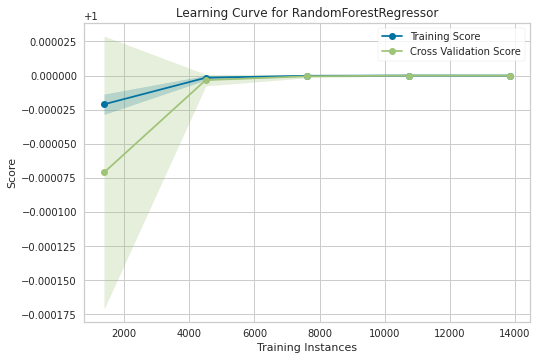

Out[32]: <matplotlib.axes._subplots.AxesSubplot at 0x7f7fc717d550>

In [0]:

from yellowbrick.model_selection import LearningCurve

# Instantiate the regression model and visualizer
model = RandomForestRegressor(max_depth=5, random_state=0)
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(Xtrain_Sparse, y_train)        # Fit the data to the visualizer
visualizer.show() 

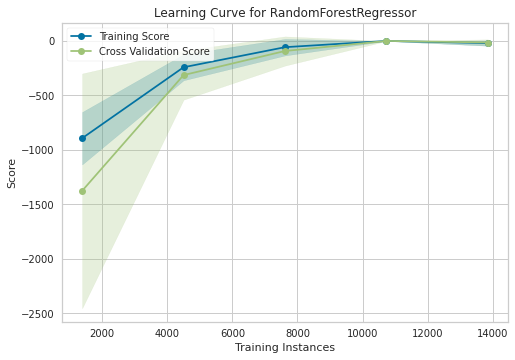

Out[33]: <matplotlib.axes._subplots.AxesSubplot at 0x7f7fc6eb9df0>

In [0]:
# Instantiate the regression model and visualizer
model = RandomForestRegressor(max_depth=5, random_state=0)
visualizer = LearningCurve(model, scoring='neg_root_mean_squared_error')

visualizer.fit(Xtrain_Sparse, y_train)        # Fit the data to the visualizer
visualizer.show() 


# Conclusions

For this hackathon Libraries in United States was selected as business to build and evaluate model to predict if new selected location will help library to sustain at that location. Due to time constraint, learning curve (Spark mostly) and limitation of hackathon environment very small data set was selected for the state of Florida. Following operations on the data apparently helped in constructing model with good prediction capabilty.

1.Precisely's location intelligence to build travel boundary

2.Combining data with census data. All features included in the final dataset

Although this was trimmed data and contained few locations from just one state this analysis indicates that census data which encodes population density in particualr geography area helps to predicting correctly. However, Major profit making businesses such as CHEGG INC, New York Library and Utah university and many such whose sales are above 1 million may need more features and may be different model and it may need more hyperparamter training.

In summary,

Adding location intelligence definately helps in building predictive model.

# What Next?

Due to time constraint, learning curve (Mainly spark/Scala used for the first time) and limitation of environment analysis and modeling was done with fewer records and fewer features. But with Precisely's SDK and including other datasets on consumer behavior, family income should improve model accuracy to correclty predict next possible location for the selected business. Also in this notebook only one modeling technique has been used without much cross validation and evaluation. That can be done with more data and it should improve predictions and model can become more accurate. Neural networks can possibly be used for modeling.

In summary following can be done to improve predictive model

1.Use more features from audience profile, family income/expenditure along with census data.

2.Use more data from all states

3.Use Neural networks for modeling

4.Include more libraries from other states. More data shall improve accuracy

5.More Hyperparameter tunning.

# References

1. <a href="http://informationr.net/ir/24-4/colis/colis1914.html"  target="_blank"> Research on Public Libraries are promoters of Social Sustainbilty </a>